# Explore a benchmark model

This notebook explores the prediction accuracy for a regression model predicting skin temperature.


The model was trained on 2019, validated on 2020 and predictions were made for 2021.


# Headline Results

* The MAE/MSE for the model was: 2.90/15.36 K 

* The MAE/MSE for ERA5 was: 3.86/27.27 K 


---

# 1. Intro

In [4]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/Benchmarking_2021/'

First let's have a quick look at the file which holds our predictions:

In [2]:
import pandas as pd
df = pd.read_parquet(path_to_model+'predictions.parquet')
display(df)

,latitude_ERA,longitude_ERA,time,MODIS_LST,skt_unnormalised,number_of_modis_observations,predictions
0,18.969549,-155.81250,2021-01-01 00:00:00,309.756989,297.985748,16,301.247101
1,18.969549,-155.53125,2021-01-01 00:00:00,301.996277,298.028717,10,300.233124
2,19.250579,-155.81250,2021-01-01 00:00:00,304.099091,298.241608,23,298.422577
3,19.250579,-155.53125,2021-01-01 00:00:00,301.439331,300.850983,45,296.881348
4,19.250579,-155.25000,2021-01-01 00:00:00,307.474731,296.481842,41,296.849670
...,...,...,...,...,...,...,...
2995351,70.117048,-145.50000,2021-12-31 23:00:00,238.555969,240.864090,22,234.325775
2995352,70.117048,-144.75000,2021-12-31 23:00:00,238.885162,242.410965,5,234.766693
2995353,70.117048,-144.00000,2021-12-31 23:00:00,239.591873,243.026199,14,236.050354
2995354,70.117048,-143.25000,2021-12-31 23:00:00,238.881363,244.018387,23,237.712082


`Latitude/longitude/time` are all self explanatory. 

`MODIS_LST` is the skin temperature (Kelvin) as measured by MODIS. It is an average over `number_of_modis_observations` points. 

`skt_unnormalised` is the skin temperature for that postion/time from ERA5. 

`predictions` is the predicted skin temperature at for that position/time from the trained model.


---

# 2. Prediction Scores 

Now lets calculate some scores (MSE,MAE) averaged over the entire predictive year. 

In [8]:
def load_predictions(path):
    
    """
    Load the predictions, calculate bias/MSE/MAE and surface average values
    """

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_bias'] = df.MODIS_LST - df.predictions
    df['model_mae']  = abs(df.MODIS_LST - df.predictions)
    df['model_mse']  = (df.MODIS_LST - df.predictions)**2
    
    
    df['ERA_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_mae'] = abs(df.MODIS_LST - df.skt_unnormalised)
    df['ERA_mse'] = (df.MODIS_LST - df.skt_unnormalised)**2



    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_bias'].mean(), df['model_bias'].median(),df['model_bias'].std())
    print("Mean/Median/Std prediction MAE:",  df['model_mae'].mean(), df['model_mae'].median(),df['model_mae'].std())
    print("Mean/Median/Std prediction MSE:",  df['model_mse'].mean(), df['model_mse'].median(),df['model_mse'].std())

    print ('------------------------------------ERA---------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['ERA_bias'].mean(), df['ERA_bias'].median(),df['ERA_bias'].std())
    print("Mean/Median/Std prediction MAE:",  df['ERA_mae'].mean(), df['ERA_mae'].median(),df['ERA_mae'].std())
    print("Mean/Median/Std prediction MSE:",  df['ERA_mse'].mean(), df['ERA_mse'].median(),df['ERA_mse'].std())

    print ('-------------------------------------------------------------------------------------------')

    
    return df


In [9]:
predictions = load_predictions(path_to_model)

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0083380835 0.18609619 3.9185727
Mean/Median/Std prediction MAE: 2.9040067 2.2035522 2.6309738
Mean/Median/Std prediction MSE: 15.355268 4.8556423 32.715736
------------------------------------ERA---------------------------------------------------
Mean/Median/Std prediction bias: -0.45144692 -0.51586914 5.202718
Mean/Median/Std prediction MAE: 3.8603764 2.9586792 3.5170455
Mean/Median/Std prediction MSE: 27.272062 8.753782 59.52169
-------------------------------------------------------------------------------------------


# 3. Prediction Error Maps

We can also plot some global maps of the prediction error:

In [16]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 

        
def global_plot(df,z,projection,vmin,vmax,cmap,absolute_values,logscale,title,markersize,savefig):
    
  
    """
    Plot the value of 'z' averaged over the year, across the globe 
    """
        
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=projection)
    cax = fig.add_axes([0.32, 0.10, 0.4, 0.0125])

    #Get data
    try:
        x = df.longitude
        y = df.latitude
    except: # different sources call lat/lon different things
        x = df.longitude_ERA
        y = df.latitude_ERA

    z1 = df[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values
    
    
    #Normalize, colorbars
    if vmin is None:
        vmin = min(z1)
    if vmax is None:
        vmax = max(z1)
        

     #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    
    
    
    
    
    
    #Scatter points
    sc = ax.scatter(x,y,transform=ccrs.PlateCarree(), #Always PlateCarree
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=16)
    cax.set_xlabel('K',fontsize=16)

    ax.set_title(title)    
    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    #ax.set_xlim(-180,180)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   
        
        

In [17]:
yearly_averaged_predictions = predictions.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 

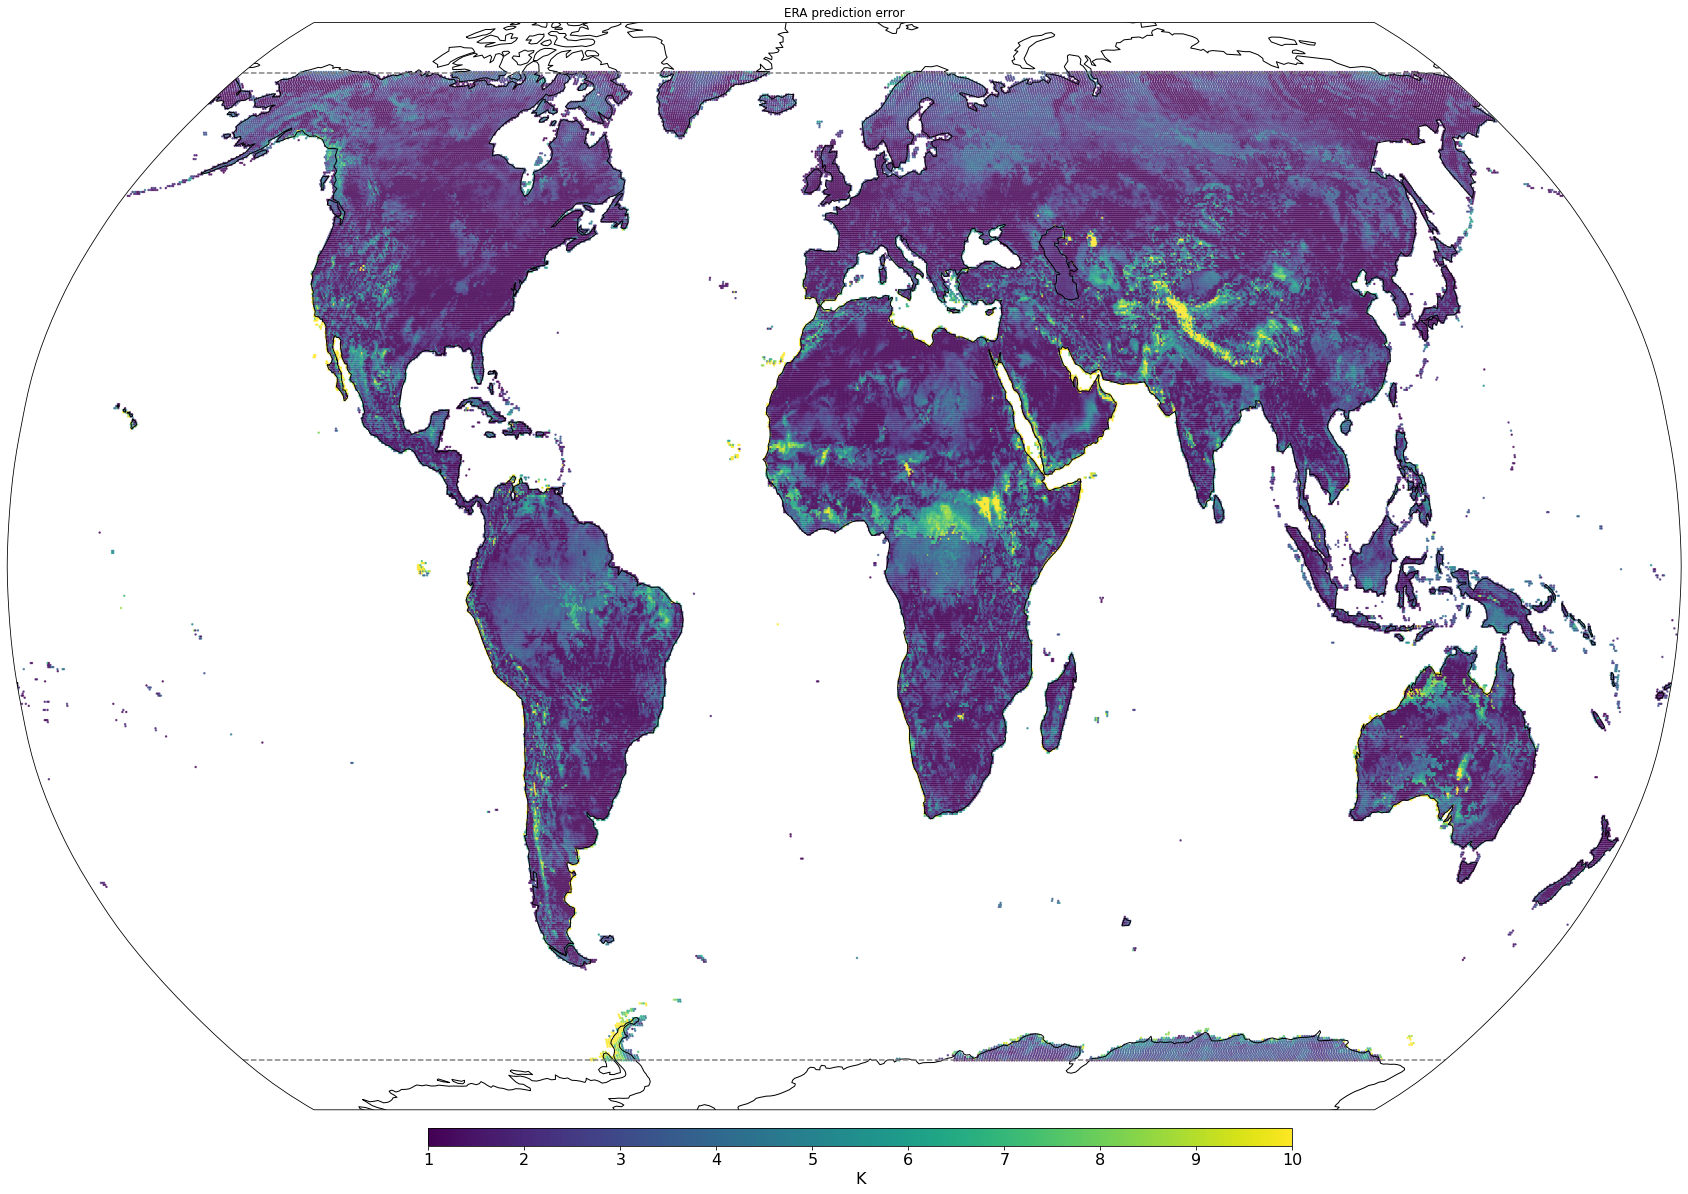

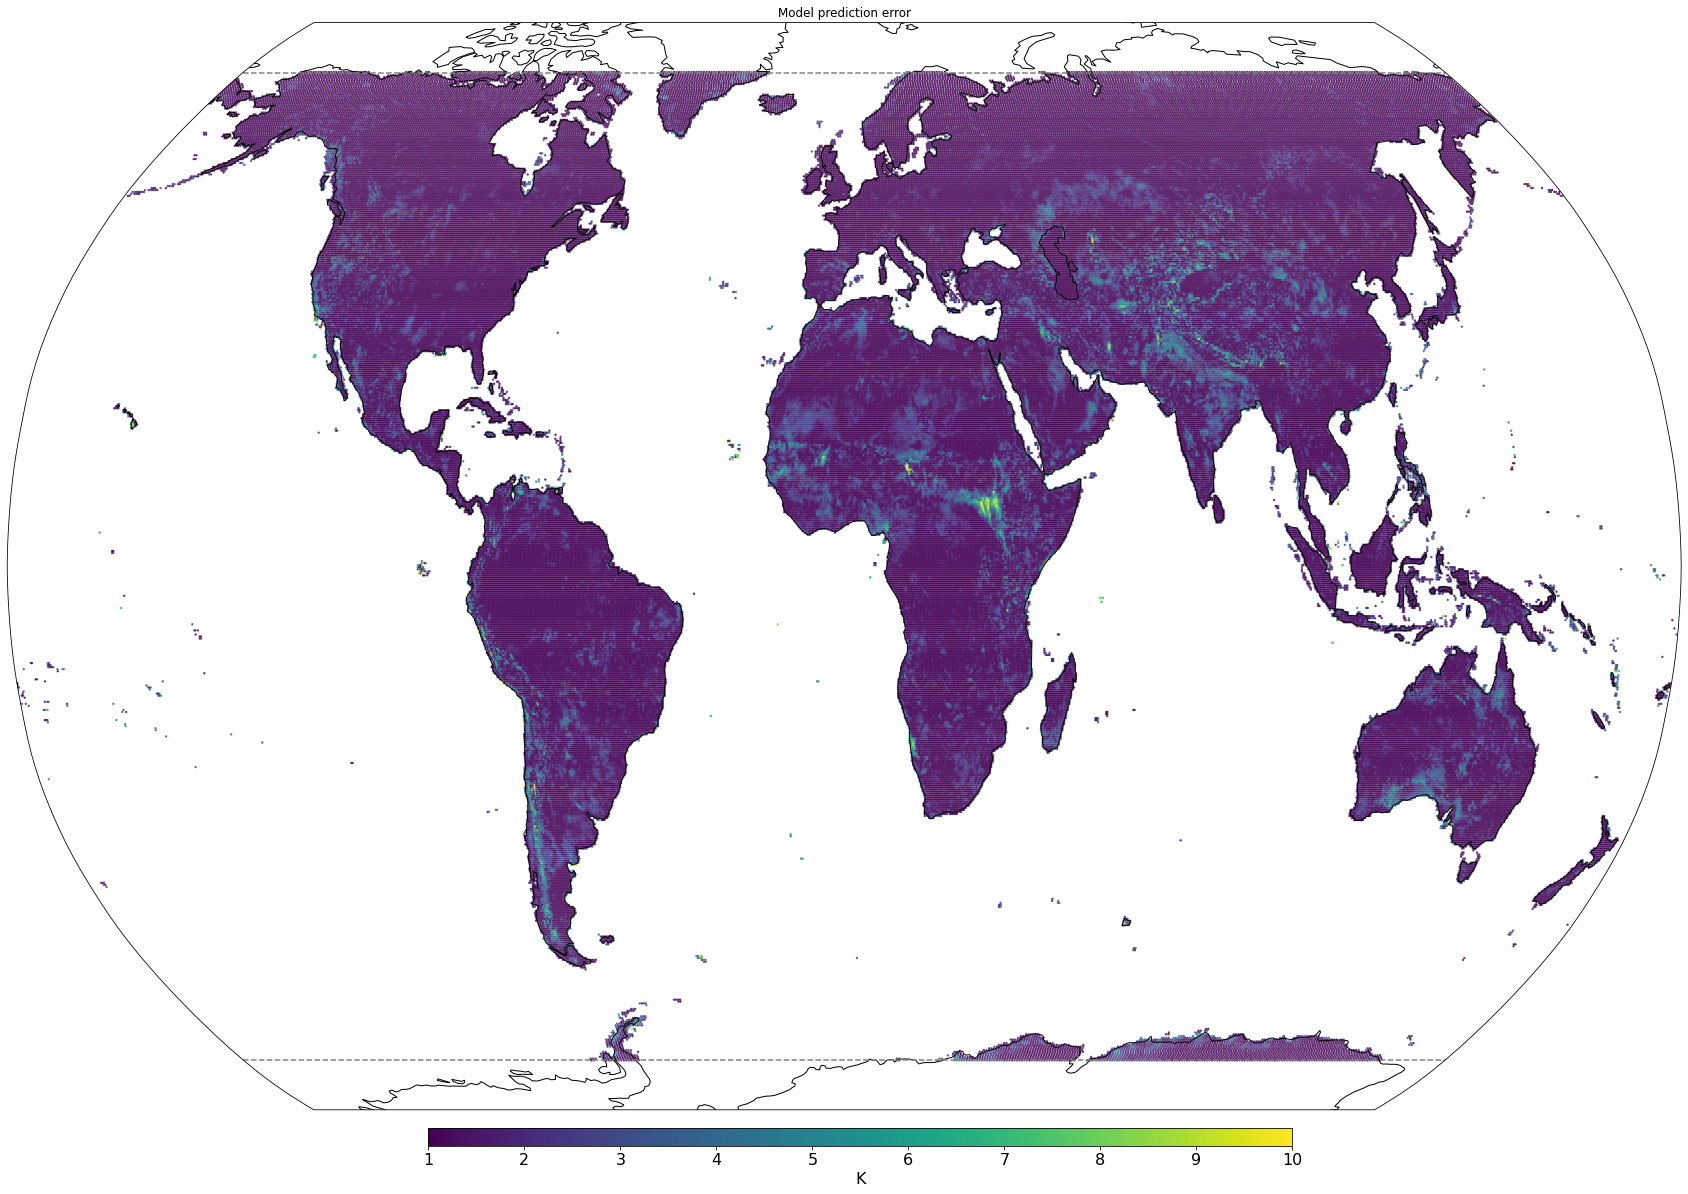

In [18]:
global_plot(yearly_averaged_predictions,
            'ERA_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title='ERA prediction error',
            markersize=2,
            savefig=None)


global_plot(yearly_averaged_predictions,
            'model_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=1,vmax=10,
            cmap=plt.cm.viridis,
            absolute_values = True,
            logscale=False,
            title='Model prediction error',
            markersize=2,
            savefig=None)


# 4. Prediction error histogram

Rather than averaging over time or space, lets just look at ALL the prediction errors.

Here we are plotting the **bias** i.e. _truth - prediction_ for the model and ERA5:

   

In [29]:
import seaborn as sns


def plot_histogram(df,y1,y2):
    
    """
    Plot 2 overlaid histograms of quantities 'y1' and 'y2'
    Legend assumes y1 = Model, y2 = ERA 
    """
    
    # Setup plot environment
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )
    

    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))



    sns.histplot(df[y1], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='Model')
    sns.histplot(df[y2], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C1',label='ERA')

    # Config
    ax1.set_xlabel('Error', fontsize = 20)
    ax1.legend().set_title(None)
    ax1.axvline(0,c='0.5', linestyle='--')

    
    #Surface some numbers
    for y in [y1,y2]:
        print (f"The mean value of {y} is {df[y].mean():.5f} with a standard deviation {df[y].std():.5f}")


    
    
    

The mean value of model_bias is 0.00834 with a standard deviation 3.91857
The mean value of ERA_bias is -0.45145 with a standard deviation 5.20272


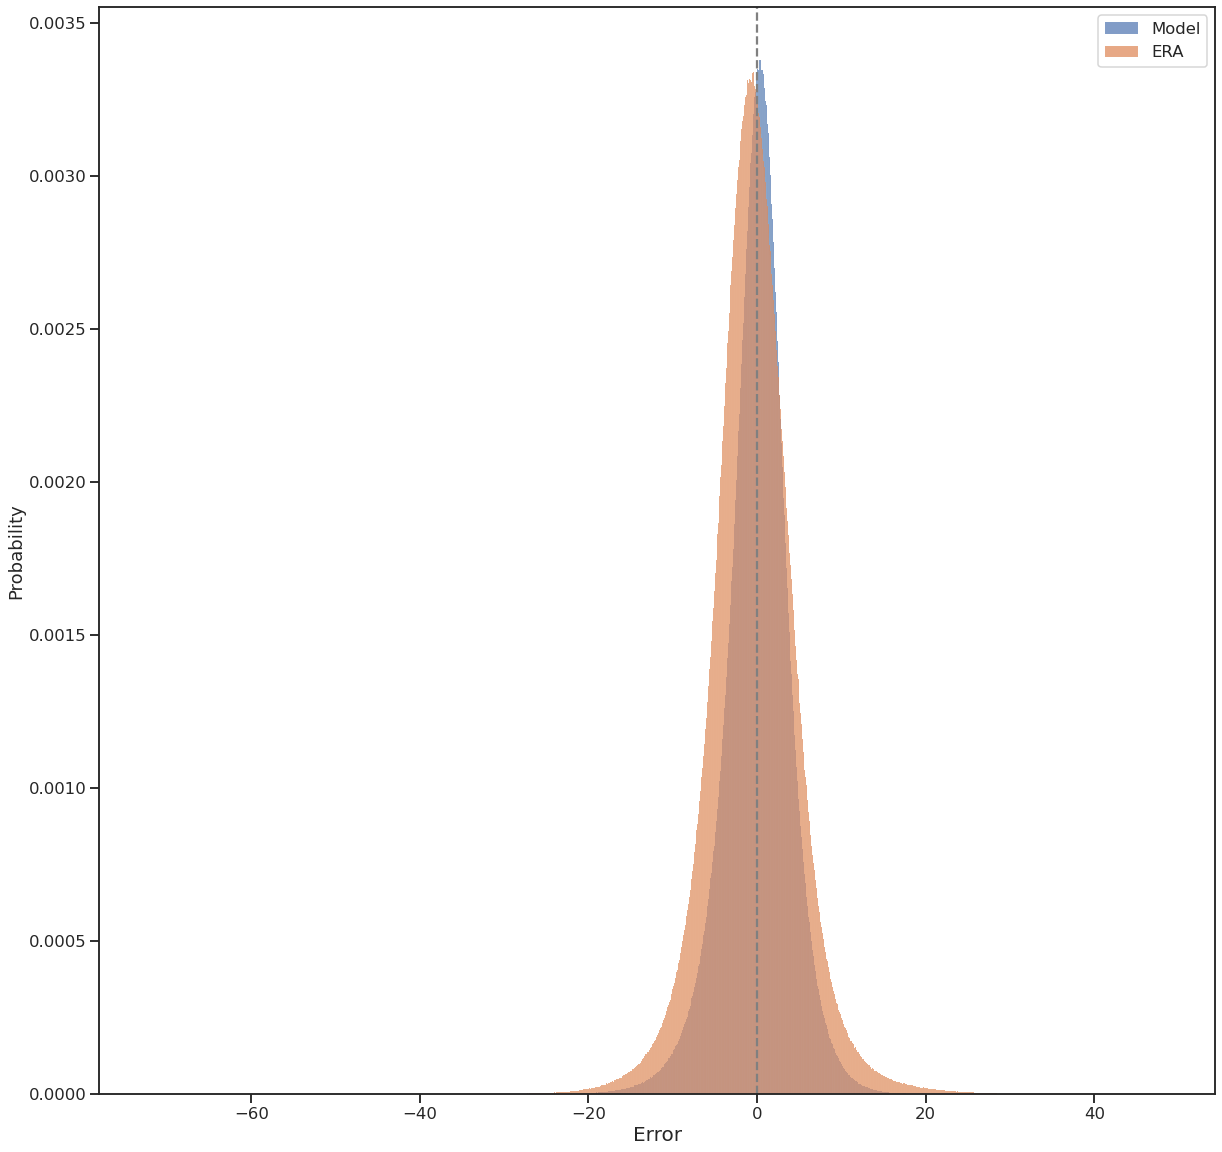

In [30]:
plot_histogram(predictions,'model_bias','ERA_bias')

---

# Appendix


Some extra information on how the model was trained

## Model Configuration


In [31]:
import json
with open(path_to_model+'configuration.json') as f:
    config=json.load(f)
    display(config['train'])

{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2019_RML.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2020_RML.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'sdor_v20',
  'cvl_v20',
  'lsm_v20',
  'isor_v20',
  'cvh_v20',
  'si10_v20',
  'anor_v20',
  'cl_v20',
  'dl_v20',
  'z_v20',
  'slor_v20',
  'clake_monthly_value',
  'cl_saline_max'],
 'batch_size': 1024,
 'epochs': 200,
 'number_of_hidden_layers': 4,
 'nodes_per_layer': [None, None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.0003

## Model training and validation

Number of epochs: 191
Minimum training loss: 15.029641151428223
Minimum validation loss: 15.505227088928223


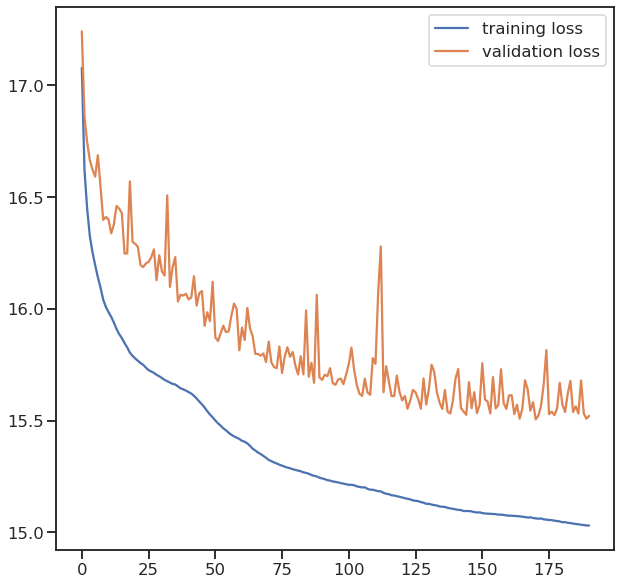

In [32]:
import numpy as np
import matplotlib.pyplot as plt
with open(path_to_model+'training_history.json') as f:
    d = json.load(f)

    training_loss = d['loss'][1:]
    validation_loss = d['val_loss'][1:]
    epochs = np.arange(len(training_loss))
    print ('Number of epochs:', len(epochs))
    print ('Minimum training loss:', min(training_loss))
    print('Minimum validation loss:', min(validation_loss))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(epochs,training_loss,label='training loss')
    plt.plot(epochs,validation_loss, label='validation loss')
    plt.legend()
        


In [1]:
import os

In [2]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/Benchmarking_2021/'

In [3]:
file_name = path_to_model + 'predictions.parquet'
file_stats = os.stat(file_name)

print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')


FileNotFoundError: [Errno 2] No such file or directory: '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/Benchmarking_2021/predictions.parquet'